In [1]:
import sys
sys.path.append("/mnt/hvae/")
sys.path.append("/mnt/mei/")

device = "cuda"

In [2]:
import torch
from src.checkpoint import Checkpoint

experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-10-07__14-17/migrated_checkpoint.pth")
model = experiment.get_model().to(device)

In [35]:
from src.hvae.model import compute_loss
import torchviz

target_block = "y"

kl_scaler = 0
tv_scaler = 0

kl_log = []

from meitorch.objective.objective_reguralization import tv_norm

def operation_target(x):
    computed, distributions = model(x, use_mean=True)
    return computed[target_block]

def operation(target_unit):
    def op(x):
        #x.to("cpu")
        tv = tv_norm(x)[0] 
        computed, distributions = model(x, use_mean=False)
        losses = compute_loss(x, distributions)
        target = computed[target_block]
        to_query = torch.flatten(target, start_dim=1)
        to_add = -losses["kl_div"] * kl_scaler + tv * tv_scaler
        kl_log.append(to_add.detach().cpu().numpy())
        activation = torch.mean(to_query[:, target_unit], dim=0)
        loss = activation + to_add
        return dict(
            kl=to_add,
            loss=-loss,
            activation=activation
        )
    return op

In [25]:
from meitorch.mei import MEI

In [16]:
#receptive_fields = white_noise_analysis(operation=operation_target, shape=(1, 40, 40), n_samples=1_000_000, sigma=0.1, device=device)

In [17]:
texture_dims = [91, 86, 110, 11, 225]
non_texture_dims = [214, 163, 223, 10, 219]

In [18]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_wna(units, save=None):
    fig = figure(figsize=(10, 3))
    for n, i in enumerate(units):
        ax = fig.add_subplot(1, 5, n + 1)
        ax.imshow(receptive_fields[i, ...].reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_wna(texture_dims, save="y_textutre_decoding_wna.png")
#plot_wna(non_texture_dims, save="y_non_textutre_encoding_wna.png")
#np.save("y_receptive_fields_1m.npy", receptive_fields)

In [8]:
from matplotlib.pyplot import figure, savefig, suptitle
import numpy as np

def plot_meis(meis, units, save=None, fig_title=""):
    fig = figure(figsize=(10, 3))
    for n, (mei, i) in enumerate(zip(meis, units)):
        ax = fig.add_subplot(1, 5, n + 1)
        image = mei.get_image()[0].detach().cpu().numpy()
        ax.imshow(image.reshape(40, 40))
        ax.set_title(f"Act: {mei.get_activation():.2f}")
        ax.axis("off")
    suptitle(fig_title)
    if save:
        savefig(save)


In [9]:
from meitorch.tools.schedules import LinearSchedule

In [10]:
def run_image_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_image_based(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_image_based(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}.png" if save else None)
    return texture_results, non_texture_results

In [28]:
image_mei_config = dict(
    iter_n=1000,
    n_samples=10, # number of samples per batch
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="adam",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser='gaussian',
    denoiser_params=dict(
        sigma=LinearSchedule(3, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),
)

NameError: name 'LinearSchedule' is not defined

100%|██████████| 2000/2000 [00:17<00:00, 115.62it/s]


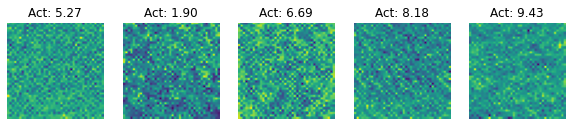

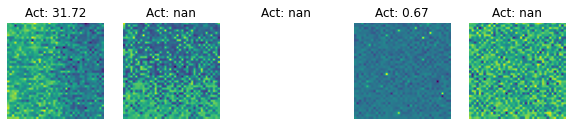

In [12]:
texture_results, non_texture_results = run_image_config(image_mei_config, save="adam_01_1000_kl_05")

In [13]:
def run_var_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_variational(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_variational(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}_var.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}_var.png" if save else None)
    return texture_results, non_texture_results

In [16]:
var_mei_config = dict(
    iter_n=250,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    
    diverse=None,

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="adam",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser=None,
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),

    #variational
    distribution='normal',
    n_samples_per_batch=(32,),
    fixed_stddev=0.4,
)

100%|██████████| 250/250 [00:02<00:00, 112.24it/s]


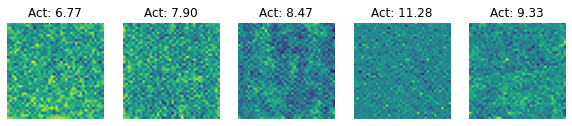

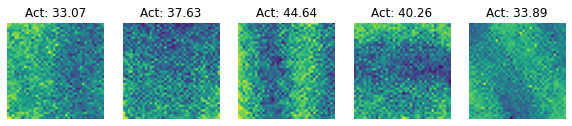

In [17]:
kl_log = []
texture_results, non_texture_results = run_var_config(var_mei_config, save="var_01_10_kl_0")

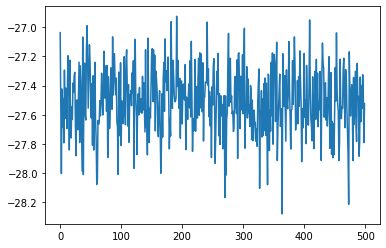

In [18]:
from matplotlib.pyplot import plot
plot(texture_results[0].loss_history)

In [18]:
from meitorch.result import MEI_distribution

In [9]:
def run_nn_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device=device))

    texture_results = []
    non_texture_results = []
    
    
    for mei, dim in zip(texture_meis, texture_dims):
        conf = config(dim)
        texture_results.append(mei.generate_nn_based(**conf))
    for mei, dim in zip(non_texture_meis, non_texture_dims):
        non_texture_results.append(mei.generate_nn_based(**config(dim)))
        
    base_filename = "texture_decoding_y_nn"
    i = 1
    import os
    while True:
        filename = f"{base_filename}_{i}.png"
        if not os.path.exists(filename):
            break
        i += 1
        
    fig_title = f"{conf['iter_n']} {conf['n_samples']} {conf['optimizer']} {conf['optimizer_params']['lr']} kl {kl_scaler}"
    
    plot_meis(texture_results, texture_dims, save=f"{base_filename}_{i}.png" if save else None, 
              fig_title=fig_title)
    plot_meis(non_texture_results, non_texture_dims, save=f"non_{base_filename}_{i}.png" if save else None, 
              fig_title=fig_title)
    return texture_results, non_texture_results

In [10]:
from meitorch.tools.generator_nn import GenerativeConvNet, GenerativeMLPNet

In [44]:
class CustomGenerative(torch.nn.Module):
    
    def __init__(self, unit, activation):
        super(CustomGenerative, self).__init__()
        experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-10-07__14-17/migrated_checkpoint.pth")
        self.model = experiment.get_model().to(device)
        init = torch.zeros((1, 250))
        init[:, unit] = activation
        self.prior = torch.nn.Parameter(init, requires_grad=True).to(device)
        for param in self.model.parameters():
            param.requires_grad = True
        #self.register_parameter("vae", model.parameters())

        
    def forward(self, batch_size, use_mean=False):
        computed = dict(y=torch.tile(self.prior, (batch_size, 1)))
        computed, _ = model.generator.blocks["z"].sample_from_prior(computed, 1, use_mean=False)
        _, distributions = model.output_block.sample_from_prior(computed, 1, use_mean=True)
        output_distribution = distributions[0] #prior
        output = output_distribution.rsample()
        #dot = torchviz.make_dot(output)
        #dot.render("customgen.png")
        return output
    

In [45]:
def nn_mei_config(unit, activation=10):
    return dict(
        iter_n=1000,
        save_every=100,        # save image every n iterations
        bias=0,               # bias of the image
        scale=1,              # scaling of the image
        n_samples=32,

        diverse=None,

        #transformations
        scaler=None,              # scaling of the image (float or schedule)
        jitter=None,             # size of translational jittering

        #normalization/clipping
        train_norm=None,        # norm adjustment during step
        norm=None,              # norm adjustment after step
        clip=None,

        #optmizer
        optimizer="adam",
        optimizer_params=dict(
            lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
            #step_size=LinearSchedule(2, 0.125)
        ),

        #preconditioning
        precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

        #denoiser
        denoiser=None,
        denoiser_params=dict(
            #sigma=LinearSchedule(1, 0.01)
            #reguralization_scaler=0.1,
            #lr=0.1,
            #num_iters=100,
        ),

        #net = GenerativeConvNet([1, 2, 4], shape=(1, 40, 40), kernel_size=9, activate_output=True, fixed_stddev=0.4)
        #net = GenerativeMLPNet([1600, 2000, 1600], (1, 40, 40), trainable_input=True, activate_output=False, distribution_base='normal')
        net = CustomGenerative(unit, 10)
    )

#TODO: 
"""
-kernel size másfélék
"""

'\n-kernel size másfélék\n'

In [46]:
texture_results, non_texture_results = run_nn_config(nn_mei_config, save=True)

  8%|▊         | 76/1000 [00:08<01:40,  9.24it/s]


KeyboardInterrupt: 

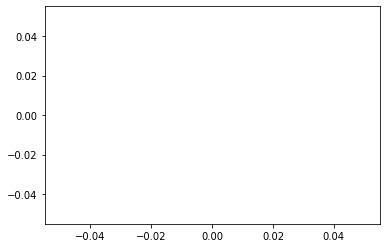

In [32]:
from matplotlib.pyplot import plot
plot(non_texture_results[2].loss_history)